<a href="https://colab.research.google.com/github/mohsenfayyaz/edge-probe/blob/main/Edge_Probing_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations & Imports

In [ ]:
! nproc
! lscpu
! nvidia-smi

2
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibr

In [ ]:
! git clone https://github.com/mohsenfayyaz/edge-probing-datasets.git
! pip install datasets
! pip install transformers
# ! pip install wandb

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display
import torch
import numpy as np
import shutil
import os
import datasets
import json
import gc
import datetime
import torch.nn as nn
from abc import ABC, abstractmethod
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import f1_score
import psutil  # RAM usage
# import wandb
# wandb.init()
print(torch.__version__)

1.8.1+cu101


# Configs

In [ ]:
class Dataset_info:
    def __init__(self, dataset_name, num_of_spans, max_span_length=5):
        self.dataset_name = dataset_name
        self.num_of_spans = num_of_spans

In [ ]:
# model_checkpoint = 'xlnet-base-cased'
# model_checkpoint = "xlnet-large-cased"
# model_checkpoint = "distilbert-base-cased"
model_checkpoint = "bert-base-cased"
# model_checkpoint = "bert-large-cased"
# model_checkpoint = "albert-xxlarge-v2"
# model_checkpoint = "t5-small"
# model_checkpoint ="t5-large"
# model_checkpoint = "mohsenfayyaz/toxicity-classifier"


# my_dataset_info = Dataset_info("dpr", num_of_spans=2)
# my_dataset_info = Dataset_info("ud", num_of_spans=2)
my_dataset_info = Dataset_info("semeval", num_of_spans=2)


MAX_RAM_USAGE = 80
MAX_CACHE_LEN = 10000
CACHE = True
POOL_METHOD = "attn"  # 'max', 'attn'
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda


# Prepare Dataset & Spans

In [ ]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  
model = AutoModel.from_pretrained(model_checkpoint)

In [ ]:
# model.save_pretrained(model_checkpoint)
# tokenizer.save_pretrained(model_checkpoint)

In [ ]:
class Utils:
    def one_hot(idx, length):
        import numpy as np
        o = np.zeros(length, dtype=np.int8)
        o[idx] = 1
        return o

In [ ]:
class Dataset_handler:
    def __init__(self, dataset_info: Dataset_info):
        self.dataset = datasets.DatasetDict()
        self.tokenized_dataset = None
        self.dataset_info = dataset_info
        self.labels_list = None

        if dataset_info.dataset_name == "dpr":
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/train.json', data_type="train")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/dev.json', data_type="dev")
            self.json_to_dataset('./edge-probing-datasets/data/dpr_data/test.json', data_type="test")
        elif dataset_info.dataset_name == "ud":
            frac = 1
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-train.json', data_type="train", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-dev.json', data_type="dev", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/ud_data/en_ewt-ud-test.json', data_type="test", fraction = frac)
        elif dataset_info.dataset_name == "semeval":
            frac = 1
            self.json_to_dataset('./edge-probing-datasets/data/semeval_data/train.all.json', data_type="train", fraction = frac)
            self.json_to_dataset('./edge-probing-datasets/data/semeval_data/test.json', data_type="dev", fraction = 0.01)
            self.json_to_dataset('./edge-probing-datasets/data/semeval_data/test.json', data_type="test", fraction = frac)
        else:
            throw("Error: Unkown dataset name!")

        print("⌛ Tokenizing Dataset and Adding One Hot Representation of Labels")
        self.tokenized_dataset = self.tokenize_input_and_one_hot_labels(self.dataset)
        # self.tokenized_dataset = self.tokenize_dataset(self.dataset)
        # print("⌛ Adding One Hot Representation of Labels")
        # self.tokenized_dataset = self.one_hot_dataset_labels(self.tokenized_dataset)
        

    # Public:
    def json_to_dataset(self, json_path, data_type="train", fraction=1):
        data_df = self.json_to_df(json_path)
        # print(data_type, "text max length:", data_df["text"].str.len().max())  # max length of texts
        if fraction != 1:
            data_df = data_df.sample(frac=fraction, random_state=1).sort_index().reset_index(drop=True)
        self.dataset[data_type] = datasets.Dataset.from_pandas(data_df)
        return self.dataset
    
    def tokenize_input_and_one_hot_labels(self, dataset):
        train_df = pd.DataFrame(dataset["train"]["label"], columns=['label'])
        dev_df = pd.DataFrame(dataset["dev"]["label"], columns=['label'])
        test_df = pd.DataFrame(dataset["test"]["label"], columns=['label'])
        self.labels_list = list(set(train_df["label"].unique()).union
                               (set(dev_df["label"].unique())).union
                               (set(test_df["label"].unique())))
        self.label_to_index = dict()
        for idx, l in enumerate(self.labels_list):
            self.label_to_index[l] = idx
        tokenized_one_hot_dataset = dataset.map(tokenize_and_one_hot,
                                                fn_kwargs={"label_to_index": self.label_to_index,
                                                           "labels_len": len(self.label_to_index),
                                                           "tokenizer": tokenizer,
                                                           "one_hot_func": Utils.one_hot
                                                           },
                                                batched=False,
                                                num_proc=None)
        return tokenized_one_hot_dataset

    # Private:
    def json_to_df(self, json_path):
        with open(json_path, encoding='utf-8') as file:
            data_list = list()
            for line in file:
                instance = json.loads(line)
                for target in instance["targets"]:
                    data_list.append({"text": instance["text"], 
                                    "span1": target["span1"],
                                    "span2": target["span2"],
                                    "label": target["label"]})
        return pd.DataFrame.from_dict(data_list)

def tokenize_and_one_hot(examples, **fn_kwargs):
    # tokenize and align spans
    thread_tokenizer = fn_kwargs["tokenizer"]
    one_hot_func = fn_kwargs["one_hot_func"]
    tokenized_inputs = thread_tokenizer(examples["text"])
    # tokenized_inputs = tokenizer(examples["text"], truncation=True, is_split_into_words=True, padding="max_length", max_length=210)
    word_ids = tokenized_inputs.word_ids()
    tokenized_inputs["span1"] = [0, 0]
    tokenized_inputs["span2"] = [0, 0]
    tokenized_inputs["span1"][0] = word_ids.index(examples["span1"][0])  # First occurance
    tokenized_inputs["span1"][1] = len(word_ids) - 1 - word_ids[::-1].index(
        examples["span1"][1] - 1) + 1  # Last occurance (+1 for open range)
    tokenized_inputs["span2"][0] = word_ids.index(examples["span2"][0])  # First occurance
    tokenized_inputs["span2"][1] = len(word_ids) - 1 - word_ids[::-1].index(
        examples["span2"][1] - 1) + 1  # Last occurance
    tokenized_inputs["span1_len"] = tokenized_inputs["span1"][1] - tokenized_inputs["span1"][0]
    tokenized_inputs["span2_len"] = tokenized_inputs["span2"][1] - tokenized_inputs["span2"][0]
    # One hot
    label_to_index = fn_kwargs["label_to_index"]
    labels_len = fn_kwargs["labels_len"]
    tokenized_inputs["one_hot_label"] = one_hot_func(label_to_index[examples["label"]], labels_len)
    return tokenized_inputs

In [ ]:
my_dataset_handler = Dataset_handler(my_dataset_info);

⌛ Tokenizing Dataset and Adding One Hot Representation of Labels


,attention_mask,input_ids,label,one_hot_label,span1,span1_len,span2,span2_len,text,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1109, 1449, 1112, 1758, 1807, 1144, 1157...","Component-Whole(e2,e1)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[14, 15]",1,"[17, 18]",1,The system as described above has its greatest...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1109, 2027, 1108, 4727, 4293, 1105, 4930...",Other,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3]",1,"[10, 11]",1,The child was carefully wrapped and bound into...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1109, 2351, 1104, 170, 2501, 4915, 2745,...","Instrument-Agency(e2,e1)","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3]",1,"[9, 14]",5,The author of a keygen uses a disassembler to ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text', 'token_type_ids'],
        num_rows: 8000
    })
    dev: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text', 'token_type_ids'],
        num_rows: 27
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'one_hot_label', 'span1', 'span1_len', 'span2', 'span2_len', 'text', 'token_type_ids'],
        num_rows: 2717
    })
})
Original Spans: {'text': 'The solute was placed inside a beaker and 5 mL of the solvent was pipetted into a 25 mL glass flask for each trial.', 'span1': [12, 13], 'span2': [20, 21], 'label': 'Entity-Destination(e1,e2)'}
Tokenized Spans: {'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'input_ids': [101, 1109, 1177, 259

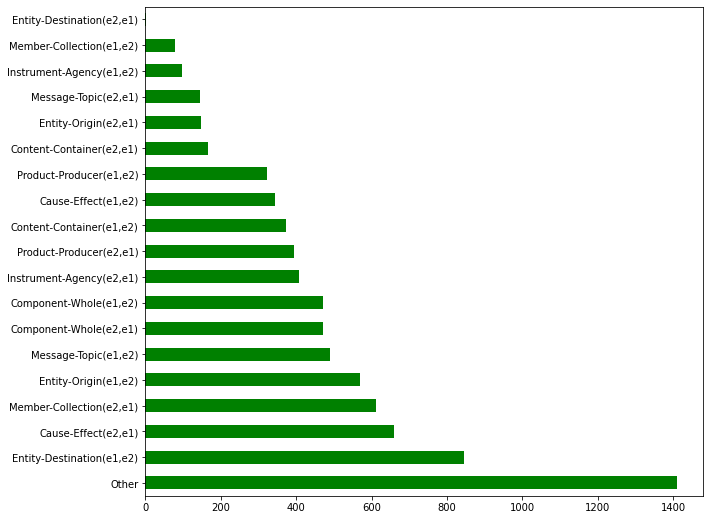

In [ ]:
# Check
rnd_idx = np.random.randint(100)
part = "train"

display(pd.DataFrame(my_dataset_handler.tokenized_dataset[part][0:3]))
print(my_dataset_handler.tokenized_dataset)
print("Original Spans:", my_dataset_handler.dataset[part][rnd_idx])
print("Tokenized Spans:", my_dataset_handler.tokenized_dataset[part][rnd_idx])
test_tokens = tokenizer.convert_ids_to_tokens(my_dataset_handler.tokenized_dataset[part][rnd_idx]["input_ids"])
print(test_tokens)

s10, s11 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][-1]
s20, s21 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][-1]
print("span1:", s10, s11, test_tokens[s10:s11])
print("span2:", s20, s21, test_tokens[s20:s21])
print("label:", my_dataset_handler.tokenized_dataset[part][rnd_idx]["label"])

pd.DataFrame(my_dataset_handler.tokenized_dataset[part]["label"], columns=['label'])["label"].value_counts().plot(kind='barh', color="green", figsize=(10, 9));

# Edge Probe

In [ ]:
class SpanRepr(ABC, nn.Module):
    """Abstract class describing span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256):
        super(SpanRepr, self).__init__()
        self.input_dim = input_dim  # embedding dim or proj dim
        self.proj_dim = proj_dim
        self.use_proj = use_proj

    @abstractmethod
    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        returns:
            [32, 13, 256]
        """
        raise NotImplementedError

    def get_input_dim(self):
        return self.input_dim

class MaxSpanRepr(SpanRepr, nn.Module):
    """Class implementing the max-pool span representation."""

    def forward(self, spans, attention_mask):
        # TODO: Vectorize this
        for i in range(len(attention_mask)):
            for j in range(len(attention_mask[i])):
                if attention_mask[i][j] == 0:
                    spans[i, :, j, :] = -1e10

        max_span_repr, max_idxs = torch.max(spans, dim=-2)
        # print(max_span_repr.shape)
        return max_span_repr

class AttnSpanRepr(SpanRepr, nn.Module):
    """Class implementing the attention-based span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256, use_endpoints=False):
        """If use_endpoints is true then concatenate the end points to attention-pooled span repr.
        Otherwise just return the attention pooled term. (use_endpoints Not Implemented)
        """
        super(AttnSpanRepr, self).__init__(input_dim, use_proj=use_proj, proj_dim=proj_dim)
        self.use_endpoints = use_endpoints
        # input_dim is embedding_dim or proj dim
        print("input_dim", input_dim)
        self.attention_params = nn.Linear(input_dim, 1)  # Learn a weight for each token: z(k)i = W(k)att e(k)i
        # Initialize weight to zero weight
        # self.attention_params.weight.data.fill_(0)
        # self.attention_params.bias.data.fill_(0)

    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        returns:
            [32, 13, 256]
        """
        if self.use_proj:
            encoded_input = self.proj(encoded_input)

        # span_mask = get_span_mask(start_ids, end_ids, encoded_input.shape[1])
        f = False
        attn_mask = torch.zeros(spans.shape)
        for i in range(len(attention_mask)):
            for j in range(len(attention_mask[i])):
                if attention_mask[i][j] == 0:
                    attn_mask[i, :, j, :] = -1e10
        # attn_mask = (1 - span_mask) * (-1e10)
        attn_logits = self.attention_params(spans) + attn_mask  # Decreasing the attention of padded spans by -1e10
        attention_wts = nn.functional.softmax(attn_logits, dim=-2)
        attention_term = torch.sum(attention_wts * spans, dim=-2)
        
        # if self.use_endpoints:
        #     batch_size = encoded_input.shape[0]
        #     h_start = encoded_input[torch.arange(batch_size), start_ids, :]
        #     h_end = encoded_input[torch.arange(batch_size), end_ids, :]
        #     return torch.cat([h_start, h_end, attention_term], dim=1)
        # else:
        #     return attention_term

        # print(spans.shape, attn_mask.shape)
        # print("attn_mask", attn_mask.shape)
        # print(attn_mask[sidx, :, :, 0:2])
        # print("attn_logits", attn_logits.shape)
        # print(attn_logits[sidx])
        # print("attention_wts", attention_wts.shape)
        # print(attention_wts[sidx, :, :, 0:2])
        # print("attention_term", attention_term.shape)
        # print(attention_term[sidx, :, 0:2])
        return attention_term.float()

def get_span_module(input_dim, method="max", use_proj=False, proj_dim=256):
    """Initializes the appropriate span representation class and returns the object.
    """
    if method == "avg":
        return AvgSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "max":
        return MaxSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff":
        return DiffSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff_sum":
        return DiffSumSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "endpoint":
        return EndPointRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent":
        return CoherentSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent_original":
        return CoherentOrigSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "attn":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coref":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim, use_endpoints=True)
    else:
        raise NotImplementedError

In [ ]:
class Edge_probe_model(nn.Module):
    def __init__(self, num_layers, input_span_len, embedding_dim, num_classes, pool_method='max', use_proj=True, proj_dim=256, hidden_dim=256, device='cuda'):
        super(Edge_probe_model, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.weighing_params = nn.Parameter(torch.ones(self.num_layers))
        self.input_dim = 2 * embedding_dim
        self.use_proj = use_proj
        self.proj_dim = proj_dim
        if use_proj:
            # Apply a projection layer to output of pretrained models
            print(embedding_dim, num_layers, proj_dim)
            self.proj1 = nn.Linear(embedding_dim, proj_dim)
            self.proj2 = nn.Linear(embedding_dim, proj_dim)
            # Update the input_dim
            self.input_dim = 2 * proj_dim
        else:
            self.proj1 = None

        self.pool_method = pool_method
        input_dim = proj_dim if use_proj else embedding_dim
        self.span1_pooling_net = get_span_module(input_dim, method=pool_method)
        self.span2_pooling_net = get_span_module(input_dim, method=pool_method)

        self.label_net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.Tanh(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, self.num_classes),
            nn.Sigmoid()
        )
        self.training_criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4, weight_decay=0)

    def forward(self, spans_torch_dict):
        span1_reprs = spans_torch_dict["span1"]
        span2_reprs = spans_torch_dict["span2"]
        span1_attention_mask = spans_torch_dict["span1_attention_mask"]
        span2_attention_mask = spans_torch_dict["span2_attention_mask"]
        # print(span1_reprs.shape)
        if self.use_proj:
            span1_reprs = self.proj1(span1_reprs)
            span2_reprs = self.proj2(span2_reprs)
        
        pooled_span1 = self.span1_pooling_net(span1_reprs, span1_attention_mask)
        pooled_span2 = self.span2_pooling_net(span2_reprs, span2_attention_mask)

        # print(my_dataset_handler.tokenized_dataset["train"][0])
        # print("SPAN1", span1_reprs[2, :, :, 0:5])
        # print("SPAN2", span2_reprs[2, :, :, 0:5])
        # print("MAX1", pooled_span1[2, :, 0:5])
        # print("MAX2", pooled_span2[2, :, 0:5])
        # raise "E"
        
        output = torch.cat((pooled_span1, pooled_span2), dim=-1)
        # print(output.shape)  # torch.Size([32, 13, 512])

        wtd_encoded_repr = 0
        soft_weight = nn.functional.softmax(self.weighing_params, dim=0)
        for i in range(self.num_layers):
            wtd_encoded_repr += soft_weight[i] * output[:, i, :]
        # wtd_encoded_repr += soft_weight[-1] * encoded_layers[:, -1, :]
        output = wtd_encoded_repr

        pred_label = self.label_net(output)
        pred_label = torch.squeeze(pred_label, dim=-1)
        return pred_label

    def summary(self):
        print(self)
        pytorch_total_params = sum(p.numel() for p in self.parameters())
        pytorch_total_params_trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("Total Parameters:    ", pytorch_total_params)
        print("Trainable Parameters:", pytorch_total_params_trainable)
        print("Pool Method:", self.pool_method)
        print("Projection:", self.use_proj, self.proj_dim)

In [ ]:
class Edge_probe_trainer:
    # Public:
    def __init__(self, language_model, dataset_handler: Dataset_handler, verbose=True, device='cuda', edge_probe_model_checkpoint=None, pool_method="max", start_eval = False, history_checkpoint=None):
        self.dataset_handler = dataset_handler
        self.language_model = language_model
        self.language_model.config.output_hidden_states = True
        self.device = device
        self.verbose = verbose
        self.start_eval = start_eval
        def vprint(text):
            if verbose:
                print(datetime.datetime.now().time(), text)
        self.vprint = vprint

        self.current_hidden_states = None
        self.last_input_ids = None
        self.cached_hidden_states = {"id_to_hidden_states": dict(), "len": 0}

        self.vprint("Moving to device")
        self.language_model.to(self.device)
        num_layers, input_span_len, embedding_dim, num_classes = self.get_language_model_properties()
        self.MLP_device = "cpu"
        if edge_probe_model_checkpoint == None:
            print("Creating New EPM")
            self.edge_probe_model = Edge_probe_model(
                num_layers = num_layers,
                input_span_len = input_span_len,
                embedding_dim = embedding_dim, 
                num_classes = num_classes,
                device = self.MLP_device,
                pool_method = pool_method
            )
        else:
            print("Starting From a Pretrained EPM")
            self.edge_probe_model = edge_probe_model_checkpoint

        if history_checkpoint is None:
            self.history = {"loss": {"train": [], "dev": [], "test": []}, 
                            "metrics": 
                            {"micro_f1": {"dev": [], "test": []}},
                            "layers_weights": []
                            }
            print("Creating New History")
        else:
            print("Using History Checkpoint")
            self.history = history_checkpoint
    
    def train(self, batch_size, epochs=3):
        tokenized_dataset = self.dataset_handler.tokenized_dataset["train"]
        tokenized_dataset_dev = self.dataset_handler.tokenized_dataset["dev"]
        tokenized_dataset_test = self.dataset_handler.tokenized_dataset["test"]

        # self.edge_probe_model.to(self.device)
        self.edge_probe_model.to(self.MLP_device)
        # self.vprint("Counting dataset rows")
        dataset_len = len(tokenized_dataset["input_ids"])
        dev_dataset_len = len(tokenized_dataset_dev)
        test_dataset_len = len(tokenized_dataset_test)
        print(f"Train on {dataset_len} samples, validate on {dev_dataset_len} samples, test on {test_dataset_len} samples")
        # dataset_len = 60
        if self.start_eval:
            self.update_history(epoch = 0)
        for epoch in range(epochs):
            running_loss = 0.0
            steps = 0
            self.draw_weights(epoch)
            print("----------------\n")
            self.edge_probe_model.train()
            for i in tqdm(range(0, dataset_len, batch_size), desc=f"[Epoch {epoch + 1}/{epochs}]", postfix={'train_loss': running_loss / steps if steps != 0 else 0}):
                # if int(i / batch_size) % 1000 == 0:
                #     print("memory:", psutil.virtual_memory().percent)
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                # print(f"WWW[{i}, {i+step})")
                
                # self.vprint("Extracting")
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # zero the parameter gradients
                self.edge_probe_model.optimizer.zero_grad()
    
                # forward + backward + optimize
                # self.vprint("Forward MLP")
                outputs = self.edge_probe_model(spans_torch_dict)
                # self.vprint("Loss")
                loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.edge_probe_model.parameters(), 5.0)
                self.edge_probe_model.optimizer.step()
                # self.vprint("Done")
    
                # print statistics
                running_loss += loss.item()
                steps += 1
                # print(f"loss: {running_loss / steps}")

            self.update_history(epoch + 1, train_loss = running_loss / steps)
            

    def calc_loss(self, tokenized_dataset, batch_size=16, print_metrics=False, just_micro=False, desc=""):
        self.edge_probe_model.eval()
        with torch.no_grad():
            running_loss = 0
            dataset_len = len(tokenized_dataset["input_ids"])
            steps = 0
            preds = None
            for i in tqdm(range(0, dataset_len, batch_size), desc=desc):
                # if int(i / batch_size) % 100 == 0:
                #     print("memory:", psutil.virtual_memory().percent, gc.collect(), psutil.virtual_memory().percent)
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # forward
                outputs = self.edge_probe_model(spans_torch_dict)
                preds = outputs if i == 0 else torch.cat((preds, outputs), 0)
                loss = self.edge_probe_model.training_criterion(outputs.to('cpu'), labels.float().to('cpu'))
                running_loss += loss.item()
                steps += 1

        preds = preds.cpu().argmax(-1)
        y_true = np.array(tokenized_dataset["one_hot_label"]).argmax(-1)
        print(preds[0:9])
        print(y_true[0:9])
        micro_f1 = f1_score(preds, y_true, average='micro')
        
        if print_metrics:
            labels_list = self.dataset_handler.labels_list
            if not just_micro:
                print(classification_report(preds, y_true, target_names=labels_list, labels=range(len(labels_list))))
            print("MICRO F1:", micro_f1)
        return running_loss / steps, micro_f1

    # Private:
    def update_history(self, epoch, train_loss = None):
        if train_loss is None:
            train_loss, train_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["train"], print_metrics=True, desc="Train Loss")
        dev_loss, dev_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["dev"], print_metrics=True, desc="Dev Loss")
        test_loss, test_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["test"], print_metrics=True, desc="Test Loss")
        self.history["loss"]["train"].append(train_loss)
        self.history["loss"]["dev"].append(dev_loss)
        self.history["loss"]["test"].append(test_loss)
        self.history["metrics"]["micro_f1"]["dev"].append(dev_f1)
        self.history["metrics"]["micro_f1"]["test"].append(test_f1)
        self.history["layers_weights"].append(self.edge_probe_model.weighing_params.tolist())
        print('[%d] loss: %.4f, val_loss: %.4f, test_loss: %.4f' % (epoch, self.history["loss"]["train"][-1], self.history["loss"]["dev"][-1], self.history["loss"]["test"][-1]))

    def draw_weights(self, epoch=0):
        if(epoch % 1 == 0):
            w = self.edge_probe_model.weighing_params.tolist()
            print(w)
            plt.bar(np.arange(len(w)), w)
            plt.ylabel('Weight')
            plt.xlabel('Layer');
            plt.show()

            print("Loss History")
            loss_history = self.history["loss"]
            x = range(len(loss_history["train"]))
            plt.plot(x, loss_history["train"])
            plt.plot(x, loss_history["dev"])
            plt.plot(x, loss_history["test"])
            plt.legend(['Train', 'Dev', 'Test'], loc='lower left')
            plt.show()

            print("Micro f1 History")
            f1_history = self.history["metrics"]["micro_f1"]
            x = range(len(f1_history["dev"]))
            plt.plot(x, f1_history["dev"])
            plt.plot(x, f1_history["test"])
            plt.legend(['Dev', 'Test'], loc='upper left')
            plt.show()

    def prepare_batch_data(self, tokenized_dataset, start_idx, end_idx, pad=False):
        # self.vprint("Extracting From Model")
        span_representations_dict = self.extract_embeddings(tokenized_dataset, start_idx, end_idx, pad=True)
        # self.vprint("To Device")
        span1_torch = torch.tensor(np.array(span_representations_dict["span1"])).float().to(self.MLP_device)  # (batch_size, #layers, max_span_len, embd_dim)
        span2_torch = torch.tensor(np.array(span_representations_dict["span2"])).float().to(self.MLP_device)
        span1_attention_mask_torch = torch.tensor(np.array(span_representations_dict["span1_attention_mask"]))
        span2_attention_mask_torch = torch.tensor(np.array(span_representations_dict["span1_attention_mask"]))
        one_hot_labels_torch = torch.tensor(np.array(span_representations_dict["one_hot_label"]))
        # self.vprint("Done")
        spans_torch_dict = {"span1": span1_torch, 
                            "span2": span2_torch, 
                            "span1_attention_mask": span1_attention_mask_torch, 
                            "span2_attention_mask": span2_attention_mask_torch, 
                            "one_hot_labels": one_hot_labels_torch}
        return spans_torch_dict

    def get_language_model_properties(self):
        span_representations_dict = self.extract_embeddings(self.dataset_handler.tokenized_dataset["train"], 0, 3, pad=True, cache=False)
        for i in span_representations_dict["span1"]:
            print(i.shape)
        span1_torch = torch.tensor(span_representations_dict["span1"])
        num_layers = span1_torch[0].shape[0]
        span_len = span1_torch[0].shape[1]
        embedding_dim = span1_torch[0].shape[2]
        if self.verbose:
            display(pd.DataFrame(span_representations_dict).head())
        return num_layers, span_len, embedding_dim, len(self.dataset_handler.labels_list)

    def pad_span(self, span_repr, max_len):
        """ pad spans in embeddings to max_len 
        input:
            span_representation: df with shape (#layers, span_len, embedding_dim)
        returns:
            padded_spans: np with shape (batch_len, num_layers, max_len, embedding_dim)
            attention_mask: np with shape (max_len), values = 1: data, 0: padding
        """
        shape = span_repr.shape
        num_layers = shape[0]
        span_original_len = shape[1]
        embedding_dim = shape[2]
        # padded_span_repr = np.zeros((num_layers, max_len, embedding_dim))
        # if span_original_len > max_len:
        #     raise Exception(f"Error: {span_original_len} is more than max_span_len {max_len}\n{span_repr.shape}")
        attention_mask = np.array([1] * span_original_len + [0] * (max_len - span_original_len), dtype=np.int8)
        padded_span_repr = np.concatenate([span_repr, np.zeros((num_layers, max_len - span_original_len, embedding_dim))], axis=1)
        # assert attention_mask.shape == (max_len, ), f"{attention_mask}, {attention_mask.shape} != ({max_len}, )"
        # assert padded_span_repr.shape == (num_layers, max_len, embedding_dim)
        return padded_span_repr, attention_mask

    def init_span_dict(self, num_of_spans, pad):
        if num_of_spans == 2:
            span_repr = {"span1": [], "span2": [], "label": [], "one_hot_label": []}
        else:
            span_repr = {"span1": [], "label": [], "one_hot_label": []}
        
        if pad:
            span_repr["span1_attention_mask"] = []
            span_repr["span2_attention_mask"] = []
        return span_repr

    def extract_embeddings(self, tokenized_dataset, start_idx, end_idx, pad=True, cache=CACHE):
        """ Extract raw embeddings for [start_idx, end_idx) of tokenized_dataset from language_model 
            
        Returns:
            extract_embeddings: DataFrame with cols (span1, span2?, label) and span shape is (range_len, (#layers, span_len, embedding_dim))
        """
        max_span_len_in_batch = max(max(tokenized_dataset[start_idx:end_idx]["span1_len"]), max(tokenized_dataset[start_idx:end_idx]["span2_len"]))
        # print("max_span_len_in_batch", max_span_len_in_batch)
        num_of_spans = self.dataset_handler.dataset_info.num_of_spans

        span_repr = self.init_span_dict(num_of_spans, pad)
        
        for i in range(start_idx, end_idx):
            hashable_input = repr(tokenized_dataset[i:i+1]["input_ids"])
            if self.last_input_ids != None and tokenized_dataset[i:i+1]["input_ids"] == self.last_input_ids:
                pass
            elif cache and hashable_input in self.cached_hidden_states["id_to_hidden_states"]:
                # idx = self.cached_hidden_states["input_ids"].index(tokenized_dataset[i:i+1]["input_ids"])
                self.current_hidden_states = self.cached_hidden_states["id_to_hidden_states"][hashable_input]
                self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
            else:
                with torch.no_grad():
                    input_torch = torch.tensor(np.array(tokenized_dataset[i:i+1]["input_ids"])).to(self.device)
                    outputs = self.language_model(input_torch)
                    current_hidden_states = np.asarray([val.detach().cpu().numpy() for val in outputs.hidden_states])
                    self.current_hidden_states = current_hidden_states[:, 0]
                    self.last_input_ids = tokenized_dataset[i:i+1]["input_ids"]
                    if (cache and 
                        self.cached_hidden_states["len"] < MAX_CACHE_LEN and
                        psutil.virtual_memory().percent < MAX_RAM_USAGE and
                        not i in self.cached_hidden_states["id_to_hidden_states"]
                        ):
                        self.cached_hidden_states["id_to_hidden_states"][hashable_input] = self.current_hidden_states
                        # self.cached_hidden_states["hidden_states"].append(self.current_hidden_states)
                        self.cached_hidden_states["len"] += 1
                        if self.cached_hidden_states["len"] % 200 == 0:
                            print("cached:", self.cached_hidden_states["len"])
                # self.vprint("c extract")
            # self.vprint("c done")
            
            row = tokenized_dataset[i]
            span1_hidden_states = self.current_hidden_states[:, row["span1"][0]:row["span1"][1], :]  # (#layer, span_len, embd_dim)
            if pad:
                s1, a1 = self.pad_span(np.array(span1_hidden_states), max_span_len_in_batch)
                span_repr["span1"].append(s1)
                span_repr["span1_attention_mask"].append(a1)
            else:
                span_repr["span1"].append(np.array(span1_hidden_states))
            if num_of_spans == 2:
                span2_hidden_states = self.current_hidden_states[:, row["span2"][0]:row["span2"][1], :]
                if pad:
                    s2, a2 = self.pad_span(np.array(span2_hidden_states), max_span_len_in_batch)
                    span_repr["span2"].append(s2)
                    span_repr["span2_attention_mask"].append(a2)
                else:
                    span_repr["span2"].append(np.array(span2_hidden_states))
            span_repr["one_hot_label"].append(row["one_hot_label"])
            span_repr["label"].append(row["label"])
        return span_repr

In [ ]:
my_edge_probe_trainer = None
edge_probe_model_checkpoint = None
history = None
gc.collect()

4383

In [ ]:
try:
    edge_probe_model_checkpoint = my_edge_probe_trainer.edge_probe_model
except:
    edge_probe_model_checkpoint = None
my_edge_probe_trainer = Edge_probe_trainer(model, 
                                           my_dataset_handler, 
                                           device=DEVICE,
                                           pool_method=POOL_METHOD,
                                           edge_probe_model_checkpoint=edge_probe_model_checkpoint,
                                           history_checkpoint=history)

18:36:21.291066 Moving to device
(13, 5, 768)
(13, 5, 768)
(13, 5, 768)


,span1,span2,label,one_hot_label,span1_attention_mask,span2_attention_mask
0,"[[[-0.36608171463012695, 0.2966233789920807, 0...","[[[-0.2837948501110077, 0.9314956665039062, 0....","Component-Whole(e2,e1)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0]"
1,"[[[0.3623086214065552, -0.06052524596452713, 0...","[[[0.8115066289901733, 0.9164725542068481, -0....",Other,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0]"
2,"[[[-0.46931636333465576, -0.326862096786499, -...","[[[-0.546301007270813, 0.32649293541908264, 0....","Instrument-Agency(e2,e1)","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]","[1, 1, 1, 1, 1]"


Creating New EPM
768 13 256
input_dim 256
input_dim 256
Creating New History


In [ ]:
my_edge_probe_trainer.edge_probe_model.summary()

Edge_probe_model(
  (proj1): Linear(in_features=768, out_features=256, bias=True)
  (proj2): Linear(in_features=768, out_features=256, bias=True)
  (span1_pooling_net): AttnSpanRepr(
    (attention_params): Linear(in_features=256, out_features=1, bias=True)
  )
  (span2_pooling_net): AttnSpanRepr(
    (attention_params): Linear(in_features=256, out_features=1, bias=True)
  )
  (label_net): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=19, bias=True)
    (5): Sigmoid()
  )
  (training_criterion): BCELoss()
)
Total Parameters:     530978
Trainable Parameters: 530978
Pool Method: attn
Projection: True 256


In [ ]:
my_edge_probe_trainer.train(batch_size = 32, epochs=50)

In [ ]:
# TODO: Cache Better to see improvement (bert base semeval)

In [ ]:
torch.save(my_edge_probe_trainer.edge_probe_model.state_dict(), "EPM_xlnet-large-cased-attn_epoch3")

In [ ]:
history = my_edge_probe_trainer.history
print(my_edge_probe_trainer.history)

{'loss': {'train': [0.12411222772300243, 0.07787149591743946, 0.061015804246068, 0.04960744550824165, 0.04051724527962506, 0.03396942213177681, 0.02771300171688199, 0.022911783036775886, 0.019568616733886303, 0.016357158753555267, 0.013525046143680811, 0.012042278207838535, 0.010600340412463993, 0.010415847609518096, 0.009047157595399768, 0.008132782383472658, 0.0067173215226503085, 0.006494808874209412, 0.006271783877105918, 0.0068565694509889, 0.004638732464052737, 0.0026125752549851313, 0.0020153284784173594, 0.00165362305927556, 0.0015670520244166256, 0.001237568670825567, 0.0010386769635952078, 0.0009063092654687352, 0.0010993626163108275, 0.001419547448225785, 0.0019831733285682277, 0.0039951323181157935, 0.005914372883853503, 0.004381841573631391, 0.0030061665354296566, 0.0021733255406143144, 0.00196496495208703, 0.0016702472285542171, 0.0015576904250483494, 0.0022246305563603528, 0.0023226430604117924, 0.001883037230465561, 0.001909977263858309, 0.0017719164761365392, 0.0019927

Loss History
{'train': [0.12411222772300243, 0.07787149591743946, 0.061015804246068, 0.04960744550824165, 0.04051724527962506, 0.03396942213177681, 0.02771300171688199, 0.022911783036775886, 0.019568616733886303, 0.016357158753555267, 0.013525046143680811, 0.012042278207838535, 0.010600340412463993, 0.010415847609518096, 0.009047157595399768, 0.008132782383472658, 0.0067173215226503085, 0.006494808874209412, 0.006271783877105918, 0.0068565694509889, 0.004638732464052737, 0.0026125752549851313, 0.0020153284784173594, 0.00165362305927556, 0.0015670520244166256, 0.001237568670825567, 0.0010386769635952078, 0.0009063092654687352, 0.0010993626163108275, 0.001419547448225785, 0.0019831733285682277, 0.0039951323181157935, 0.005914372883853503, 0.004381841573631391, 0.0030061665354296566, 0.0021733255406143144, 0.00196496495208703, 0.0016702472285542171, 0.0015576904250483494, 0.0022246305563603528, 0.0023226430604117924, 0.001883037230465561, 0.001909977263858309, 0.0017719164761365392, 0.001

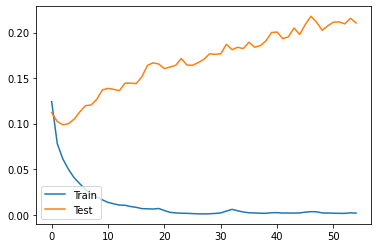

.
Micro f1 History
{'dev': [0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.7037037037037037, 0.7037037037037037, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.7037037037037037, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7037037037037037, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7037037037037037, 0.7037037037037037, 0.7037037037037037, 0.7037037037037037, 0.7407407407407407, 0.7407407407407407, 0.7037037037037037, 0.7407407407407407, 0.7037037037037037, 0.7777777777777778, 0.6666666666666666, 0.7407407407407407, 0.7037037037037037, 0.7407407407407407, 0.7037037037037037, 0.7777777777777778, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.7777777777777778, 0.7407407407407407, 0.7777777777777778, 0.7407407407407407, 0.7037037037037037, 0.7407407407407407, 0.7037037037037037, 0.8148148148148148, 0.8148148148148148, 0.7777777777

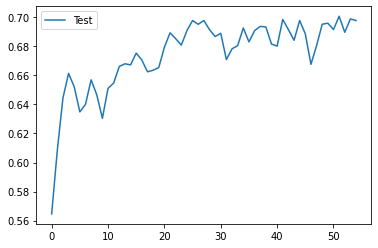

.


In [ ]:
print("Loss History")
print(my_edge_probe_trainer.history["loss"])
loss_history = my_edge_probe_trainer.history["loss"]
x = range(len(loss_history["train"]))
plt.plot(x, loss_history["train"])
# plt.plot(x, loss_history["dev"])
plt.plot(x, loss_history["test"])
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()
print(".")

print("Micro f1 History")
f1_history = my_edge_probe_trainer.history["metrics"]["micro_f1"]
print(f1_history)
x = range(len(f1_history["dev"]))
# plt.plot(x, f1_history["dev"])
plt.plot(x, f1_history["test"])
plt.legend(['Test'], loc='upper left')
plt.show()
print(".")